In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.build import mx2
from abtem import *
from abtem.structures import orthogonalize_cell

# Is Nyquist sampling good enough?

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (3, 2, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

In [3]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, device='gpu')

potential = Potential(atoms, sampling=.02, projection='finite', slice_thickness=1, parametrization='kirkland')

detector = AnnularDetector(inner = 50, outer=200)

In [4]:
end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan_nyquist = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9, endpoint=False)

gridscan_fine = gridscan_nyquist.copy()
gridscan_fine.sampling = (gridscan_nyquist.sampling[0] / 4, gridscan_nyquist.sampling[1] / 4)

measurement_nyquist = probe.scan(gridscan_nyquist, detector, potential, pbar=True)
measurement_fine = probe.scan(gridscan_fine, detector, potential, pbar=True)

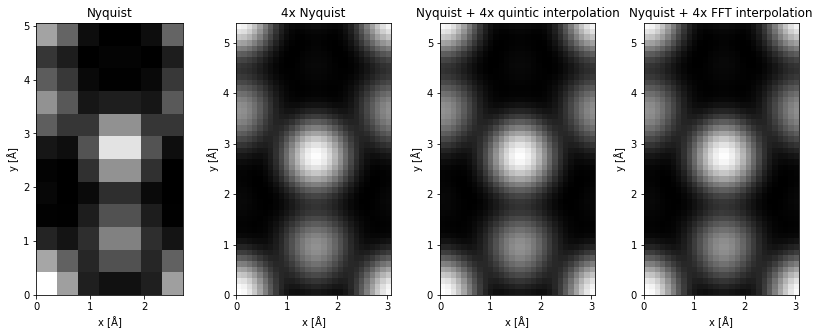

In [5]:
interpolated_quintic = measurement_nyquist.interpolate(gridscan_fine.sampling, kind='quintic')
interpolated_fft = measurement_nyquist.interpolate(gridscan_fine.sampling, kind='fft')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14,5))

measurement_nyquist.show(ax=ax1, title='Nyquist')
measurement_fine.show(ax=ax2, title='4x Nyquist')
interpolated_quintic.show(ax=ax3, title='Nyquist + 4x quintic interpolation');
interpolated_fft.show(ax=ax4, title='Nyquist + 4x FFT interpolation');

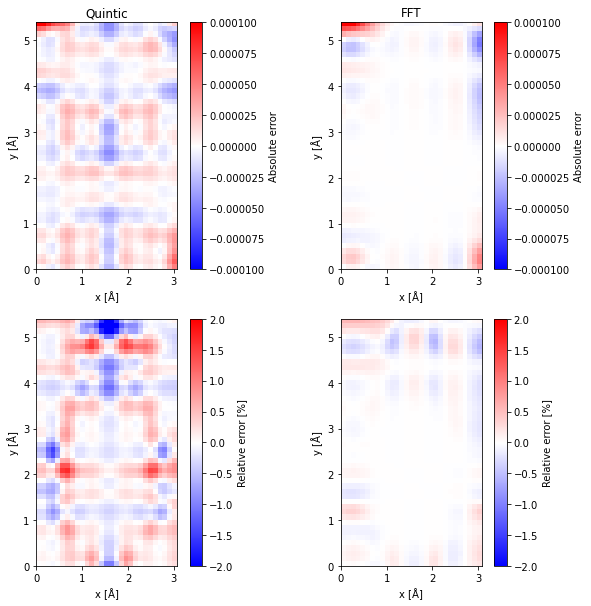

In [6]:
abs_err_quintic = (interpolated_quintic - measurement_fine)
abs_err_fft = (interpolated_fft - measurement_fine) 

rel_err_quintic = (interpolated_quintic - measurement_fine) / interpolated_quintic.array * 100.
rel_err_fft = (interpolated_fft - measurement_fine) / interpolated_fft.array * 100.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

ax1, im1 = abs_err_quintic.show(ax=ax1, title='Quintic', cmap='bwr', vmin=-1e-4, vmax=1e-4)
ax2, im2 = abs_err_fft.show(ax=ax2, title='FFT', cmap='bwr', vmin=-1e-4, vmax=1e-4)
ax3, im3 = rel_err_quintic.show(ax=ax3, cmap='bwr', vmin=-2, vmax=2)
ax4, im4 = rel_err_fft.show(ax=ax4, cmap='bwr', vmin=-2, vmax=2)

plt.colorbar(im1, ax=ax1, label='Absolute error');
plt.colorbar(im2, ax=ax2, label='Absolute error');
plt.colorbar(im3, ax=ax3, label='Relative error [%]');
plt.colorbar(im4, ax=ax4, label='Relative error [%]');